In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
index_lst = np.arange(-2, 4, 0.5)
x_lst = np.asarray([-1.5, 0.5, -1., 1., 1.5, -0.5, 0., 3.5, 3., -2., 2., 2.5])
w_lst = np.asarray([-2., 3., -1.5, 2.5, 1.5, 0., 1., 3.5, 2., -0.5, -1., 0.5])


y_lst = w_lst*x_lst
y_tensor = torch.from_numpy(np.asarray(y_lst))
y_softmax = torch.softmax(y_tensor, dim=0)
y_softmax = y_softmax.data.cpu().numpy()*1

w_tensor = torch.from_numpy(np.asarray(w_lst))
w_norm = torch.norm(w_tensor, p=2, dim=0, keepdim=True).clamp(min=1e-12)
w_norm = torch.div(w_tensor, w_norm)
y_tensor = torch.from_numpy(np.asarray(x_lst))
x_norm = torch.norm(y_tensor, p=2, dim=0, keepdim=True).clamp(min=1e-12)
x_norm = torch.div(y_tensor, x_norm)
y_cosine = w_norm*x_norm

y_3amsoftmax = torch.softmax(3*(y_cosine-0.25), dim=0)
y_3amsoftmax = y_3amsoftmax.data.cpu().numpy()

y_30amsoftmax = torch.softmax(30*(y_cosine-0.25), dim=0)
y_30amsoftmax = y_30amsoftmax.data.cpu().numpy()*1

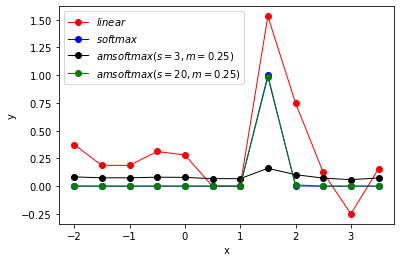

In [3]:
plt.plot(index_lst, y_lst/8, color="r", linestyle="-", marker="o", linewidth=1, label='$linear$')
plt.plot(index_lst, y_softmax, color="b", linestyle="-", marker="o", linewidth=1, label='$softmax$')
plt.plot(index_lst, y_3amsoftmax, color="k", linestyle="-", marker="o", linewidth=1, label='$amsoftmax(s=3, m=0.25)$')
plt.plot(index_lst, y_30amsoftmax, color="g", linestyle="-", marker="o", linewidth=1, label='$amsoftmax(s=20, m=0.25)$')
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

In [4]:
import torch
print(torch.cuda.is_available())

False


In [5]:
# _*_ encoding:utf-8

In [6]:
import torch
import torch.nn as nn

In [7]:
class AMSoftmax(nn.Module):
    def __init__(self,
                in_feats,
                n_classes=10,
                m=0.35,
                s=30):
        super(AMSoftmax, self).__init__()
        self.m = m
        self.s = s
        self.in_feats = in_feats
        self.W = torch.nn.Parameter(torch.randn(in_feats, n_classes), requires_grad=True)
        self.ce = nn.CrossEntropyLoss()
        nn.init.xavier_normal_(self.W, gain=1)
        
    def forward(self, x, lb):
        assert x.size()[0] == lb.size()[0]
        assert x.size()[1] == self.in_feats
        
        x_norm = torch.norm(x, p=2, dim=1, keepdim=True).clamp(min=1e-12)
        x_norm = torch.div(x, x_norm)
        
        w_norm = torch.norm(self.W, p=2, dim=0, keepdim=True).clamp(min=1e-12)
        w_norm = torch.div(self.W, w_norm)
        
        costh = torch.mm(x_norm, w_norm)
        print(x_norm.shape, w_norm.shape, costh.shape)
        
        lb_view = lb.view(-1, 1)
        if lb_view.is_cuda: lb_view = lb_view.cpu()
        delt_costh = torch.zeros(costh.size()).scatter_(1, lb_view, self.m)
        
        if x.is_cuda: delt_costh = delt_costh.cuda()
        costh_m = costh - delt_costh
        costh_m_s = self.s * costh_m
        loss = self.ce(costh_m_s, lb)
        return loss

In [8]:
if __name__ == '__main__':
    criteria = AMSoftmax(1024,10)
    a = torch.randn(20,1024)
    lb = torch.randint(0,10,(20,),dtype=torch.long)
    loss = criteria(a, lb)
    loss.backward()
    
    print(loss.detach().numpy())
    print(list(criteria.parameters())[0].shape)
    print(type(next(criteria.parameters())))

torch.Size([20, 1024]) torch.Size([1024, 10]) torch.Size([20, 10])
12.857945
torch.Size([1024, 10])
<class 'torch.nn.parameter.Parameter'>


## Ending， Find for the next day, hope I can be a easy boy 